# Stock Trades by Members of the US House of Representatives

This project uses public data about the stock trades made by members of the US House of Representatives. This data is collected and maintained by Timothy Carambat as part of the [House Stock Watcher](https://housestockwatcher.com/) project. The project describes itself as follows:

> With recent and ongoing investigations of incumbent congressional members being investigated for potentially violating the STOCK act. This website compiles this publicly available information in a format that is easier to digest then the original PDF source.
>
> Members of Congress must report periodic reports of their asset transactions. This website is purely for an informative purpose and aid in transparency.
>
> This site does not manipluate or censor any of the information from the original source. All data is transcribed by our community of contributors, which you can join for free by going to our transcription tool. Our moderation team takes great care in ensuring the accuracy of the information.
>
> This site is built and maintained by Timothy Carambat and supported with our contributors.

Some interesting questions to consider for this data set include:

- Is there a difference in stock trading behavior between political parties? For example:
    - does one party trade more often?
    - does one party make larger trades?
    - do the two parties invest in different stocks or sectors? For instance, do Democrats invest in Tesla more than Republicans?
- What congresspeople have made the most trades?
- What companies are most traded by congresspeople?
- Is there evidence of insider trading? For example, Boeing stock dropped sharply in February 2020. Were there a suspiciously-high number of sales of Boeing before the drop?
- When are stocks bought and sold? Is there a day of the week that is most common? Or a month of the year?

### Getting the Data

The full data set of stock trade disclosures is available as a CSV or as JSON at https://housestockwatcher.com/api.

This data set does not, however, contain the political affiliation of the congresspeople. If you wish to investigate a question that relies on having this information, you'll need to find another dataset that contains it and perform a merge. *Hint*: Kaggle is a useful source of data sets.


### Cleaning and EDA

- Clean the data.
    - Certain fields have "missing" data that isn't labeled as missing. For example, there are fields with the value "--." Do some exploration to find those values and convert them to null values.
    - You may also want to clean up the date columns to enable time-series exploration.
- Understand the data in ways relevant to your question using univariate and bivariate analysis of the data as well as aggregations.


### Assessment of Missingness

- Assess the missingness per the requirements in `project03.ipynb`

### Hypothesis Test / Permutation Test
Find a hypothesis test or permutation test to perform. You can use the questions at the top of the notebook for inspiration.

# Summary of Findings

### Introduction

The following notebook analyzes publicly available information regarding stock trades made by US House of Representatives members to reach inferences. We first cleaned up the dataset and combined _The 116th U.S. House of Representatives_ at [https://www.kaggle.com/datasets/aavigan/house-of-representatives-congress-116](https://www.kaggle.com/datasets/aavigan/house-of-representatives-congress-116) which contains information regarding political affiliation of congresspeople. Next, we evaluate the dataset's `owner` column's missingness association.

After that, we began processing the dataset for insights, and try to explore answers to the following questions:
- Does one party trade more often?
- Does one party make larger trades?
- What congresspeople have made the most trades?
- What companies are most traded by congresspeople?
- When are stocks bought and sold? Is there a day of the week that is most common? Or a month of the year?

### Cleaning and EDA

After obtaining the complete dataset of stock trade disclosures from https://housestockwatcher.com/api, we discover that the data need to be cleaned up since they are fairly untidy. To clean it, we did what is shown below:
1. Change `disclosure_date` and `transaction_date` column to `datetime` type.
2. Replace '--' value in `ticker` column with `np.NaN`.
3. Replace '--' value in `owner` column with `np.NaN`.
4. Convert `amount` to a `pd.Categorical` series.

The political affiliation of congressmen is missing from the dataset after it has been cleaned up, therefore we choose to utilize one from __Kaggle__ at [https://www.kaggle.com/datasets/aavigan/house-of-representatives-congress-116](https://www.kaggle.com/datasets/aavigan/house-of-representatives-congress-116). Due of the distinctions in the names between the two datasets, we combined them using the first and last names of each participant. Then we examine a few rare occurrences and manually resolve them. We were able to successfully integrate stock trade activity with representative political allegiance as an outcome. 

Moving on, we process to EDA and find out that:
- `owner`, `ticker`, `transaction_date`, and `asset_description` are 4 columns that contain missing data, some of the missingness in `transaction_date` is because of the incorrect value. For example, there are a few cell with value `0009-06-09` which is clearly not a valid date. 
- `transaction_date` range between `2012-06-19` and `2022-10-21`.
- Most of the congresspeople are either from `Democrat` or `Republican`, there is only one house member who is listed as `Independent` regrading their political affiliation.

#### What congresspeople have made the most trades? & What congresspeople have made the largest amount of trades? 
- By plotting the value counts of `representative` column, we have discovered that the representative __Josh Gottheimer__ has made the most trades.
- By plotting the value counts of `representative` column, we have discovered that the representative __Kevin Hern__ has made the largest amount of trades.


#### What companies are most traded by congresspeople?
- By plotting the value counts of `ticker` column, we have discovered that the ticker __MSFT__, which is __Microsoft Corp.__, has the most trade transactions.

#### When are stocks bought and sold? Is there a day of the week that is most common? Or a month of the year?
- By grouping the dateset by weekday of `transaction_date`, such that most of the transactions happened during weekdays, while only a tiny amount of transactions are done in weekend. Among weekdays, __Thurday__ seems to have a slightly higher transaction volume.
- By grouping the dataset by month of `transation_date`, we discover that __February__ is the month has largest volume of transactions.

### Assessment of Missingness

In this section we decided to evaluate the missingness of `owner` column as it has the most missing values across all columns. It has values like `self`, `joint`, `dependent`, and `np.NaN`. We think the missingness of `owner` column could be associated with `type` column. This concept arises from the fact that `type` describes the sort of transaction that is performed; if the type of transaction is not a stock exchange, it is less likely to fall into the `self`, `joint`, or `dependant` categories and end up as an empty value.

In order to validate this assumption, we have to perform a permutation test. To begin with, we determine the test statistic to be __Total Variation Distance (TVD)__, as `type` is a categorical data. Then, we calculate the observed statistic for the original dataset, which is `0.07390`. Afterwards, we shuffle the `owner` column and calculate the simulate statistics. By repeating this prcoess for 5,000 times, we then calculate the p-value for this permutation. As a result, we get a p-value of `0.0` which indicates that none of the simulate statistics has a more extreme result than the observed statistics. In conclusion, we conclude that the missingness of `owner` is __Missing at Random (MAR)__, and it's dependent on `type` column the most.

### Hypothesis Test

#### Which party trade more often?

* **Null hypothesis**: the distribution of trading frequency among congresspeople from different party is the same. The difference between the two observed sample is due to chance.

* **Alternative hypothesis**: the distribution of trading frequency among congresspeople from different party are different.

For the test statistics, we calculate the average trading transactions per month of each party and take the absolute difference between them. The observed statistics is `58.5469`, and we shuffle the `party` column and run the permutation test for 5,000 times. At the end, we get a p-value of `0.8756`, which indicates that majority of the permutation test cases have more extreme result than the observed statistics. Therefore, we __fail to reject__ the null hypothesis, the distribution of trading frequency among congresspeople from various parties is probrably the same.

#### Which party make larger trades?

* **Null hypothesis**: the distribution of trading amount among congresspeople from different party is the same. The difference between the two observed samples is due to chance.

* **Alternative hypothesis**: In the US, the distributions of trading amount of the two groups are different.

For the test statistics, we calculate the mean difference of trading amount across the two party. The observed statistics is 11862, and we shuffle the party column and run the permutation test for 5,000 times. At the end, we get a p-value of around 0.03 which falls within the rejecting area of a significant level of 0.05 that indicates the distribution of trading amount among congresspeople from different party might not be the same and Democrat might be having a larger trading amount than the Republican.


# Code

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Load transaction dataset

In [3]:
transactions = pd.read_csv('data/all_transactions.csv')
transactions.head()

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd
0,2021,10/4/21,9/27/21,joint,BP,BP plc,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
1,2021,10/4/21,9/13/21,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
2,2021,10/4/21,9/10/21,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
3,2021,10/4/21,9/28/21,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
4,2021,10/4/21,9/17/21,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Hon. Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False


In [23]:
combined.to_csv("data/congress_trading")

### Cleaning and EDA

In [4]:
cleaned = transactions.copy()

# convert `disclosure_date`, `transaction_date` to datetime type
cleaned['disclosure_date'] = pd.to_datetime(cleaned['disclosure_date'])
cleaned['transaction_date'] = pd.to_datetime(cleaned['transaction_date'], errors='coerce')

# change `ticker` null values
cleaned['ticker'] = cleaned['ticker'].replace('--', np.NaN)

# convert `amount` to categorical type
cleaned['amount'] = pd.Categorical(cleaned['amount'])

cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15674 entries, 0 to 15673
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   disclosure_year         15674 non-null  int64         
 1   disclosure_date         15674 non-null  datetime64[ns]
 2   transaction_date        15667 non-null  datetime64[ns]
 3   owner                   9661 non-null   object        
 4   ticker                  14378 non-null  object        
 5   asset_description       15670 non-null  object        
 6   type                    15674 non-null  object        
 7   amount                  15674 non-null  category      
 8   representative          15674 non-null  object        
 9   district                15674 non-null  object        
 10  ptr_link                15674 non-null  object        
 11  cap_gains_over_200_usd  15674 non-null  bool          
dtypes: bool(1), category(1), datetime64[ns](2), in

In [5]:
cleaned.isna().sum()


disclosure_year              0
disclosure_date              0
transaction_date             7
owner                     6013
ticker                    1296
asset_description            4
type                         0
amount                       0
representative               0
district                     0
ptr_link                     0
cap_gains_over_200_usd       0
dtype: int64

### Combine with political affliation dataset

In [6]:
# remove unwanted name suffixs
suffixs = ['Hon\\.', 'Mr\\.', 'Mrs\\.', 'None', 'Aston', 'S\\.', 'W\\.']
cleaned['representative'] = (cleaned['representative']
                             .str.replace('|'.join(suffixs), '', regex=True)
                             .str.strip())

cleaned['representative'].head()


0      Virginia Foxx
1      Virginia Foxx
2      Virginia Foxx
3      Virginia Foxx
4    Alan  Lowenthal
Name: representative, dtype: object

In [7]:
# split representative name into `first_name` and `last_name` for later merge 
cleaned['first_name'] = cleaned['representative'].apply(lambda x: x.split()[0].lower())
cleaned['last_name'] = cleaned['representative'].apply(lambda x: x.split()[-1].lower())

# fix special cases
cleaned.loc[cleaned['representative'] == 'Neal Patrick Dunn MD, FACS', 'last_name'] = 'dunn'

cleaned['first_name'].head()


0    virginia
1    virginia
2    virginia
3    virginia
4        alan
Name: first_name, dtype: object

In [8]:
# import member table 1
members1 = pd.read_csv('data/us-house.csv')
members1 = members1[['party', 'first_name', 'last_name']]
members1['first_name'] = members1['first_name'].str.lower()
members1['last_name'] = members1['last_name'].str.lower()
members1['party'] = members1['party'].str.capitalize()

members1.head(10)


,party,first_name,last_name
0,Republican,don,young
1,Republican,jerry,carl
2,Republican,felix,moore
3,Republican,mike,rogers
4,Republican,robert,aderholt
5,Republican,mo,brooks
6,Republican,gary,palmer
7,Democrat,terri,sewell
8,Republican,rick,crawford
9,Republican,french,hill


In [9]:
# import member table 2
members2 = pd.read_csv('data/house_members.csv')
members2['first_name'] = members2['name'].apply(
    lambda x: x.split('-')[0].lower())
members2['last_name'] = members2['name'].apply(
    lambda x: x.split('-')[-1].lower())
members2 = members2.rename(columns={'current_party': 'party'})[
    ['first_name', 'last_name', 'party']]

# unify party values
members2.loc[members2['party'] == 'Democratic', 'party'] = 'Democrat'

members2.head(10)


,first_name,last_name,party
0,ralph,abraham,Republican
1,alma,adams,Democrat
2,robert,aderholt,Republican
3,pete,aguilar,Democrat
4,rick,allen,Republican
5,colin,allred,Democrat
6,justin,amash,Independent
7,mark,amodei,Republican
8,kelly,armstrong,Republican
9,jodey,arrington,Republican


In [10]:
# combine 2 member tables
members = (pd.concat([members1, members2])
           .sort_values(['first_name', 'last_name'])
           .drop_duplicates(subset=['first_name', 'last_name'])
           .reset_index(drop=True))

# fix mismatch names
members.loc[members['first_name'] == 'k', 'first_name'] = 'k.'
members.loc[members['first_name'] == 'raul', 'first_name'] = 'raúl'
members.loc[members['first_name'] == 'wm', 'first_name'] = 'wm.'
members.loc[members['first_name'] == 'ro', 'first_name'] = 'rohit'
members.loc[members['first_name'] == 'cynthia', 'first_name'] = 'cindy'
members.loc[members['last_name'] == 'allen', 'first_name'] = 'richard'
members.loc[members['last_name'] == 'steube', 'first_name'] = 'greg'
members.loc[members['last_name'] == 'banks', 'first_name'] = 'james'
members.loc[(members['first_name'] == 'j') & (
    members['last_name'] == 'hill'), 'first_name'] = 'james'
members.loc[(members['first_name'] == 'mike') & (
    members['last_name'] == 'garcia'), 'first_name'] = 'michael'
members.loc[members['last_name'] == 'crenshaw', 'first_name'] = 'daniel'
members.loc[members['last_name'] == 'taylor', 'first_name'] = 'nicholas'
members.loc[members['last_name'] == 'gallagher', 'first_name'] = 'michael'
members.loc[(members['first_name'] == 'gregory') & (
    members['last_name'] == 'murphy'), 'first_name'] = 'greg'
members.loc[members['first_name'] == 'ashley', 'last_name'] = 'arenholz'
members.loc[members['last_name'] == 'buck', 'first_name'] = 'kenneth'
members.loc[members['last_name'] == 'costa', 'first_name'] = 'james'
members.loc[members['last_name'] == 'hagedorn', 'first_name'] = 'james'

# drop duplicate rows
members = members.drop_duplicates(subset=['first_name', 'last_name'])

# output cleaned representative table
members.to_csv('data/cleaned_members.csv', index=False)

members.shape
members

,party,first_name,last_name
0,Republican,a,ferguson
1,Democrat,a,mceachin
2,Democrat,abby,finkenauer
3,Democrat,abigail,spanberger
4,Republican,adam,kinzinger
...,...,...,...
543,Democrat,wm.,clay
544,Democrat,xochitl,small
545,Republican,young,kim
546,Democrat,yvette,clarke


In [11]:
# transaction table with member info table
combined = cleaned.merge(members, how='left', on=['first_name', 'last_name'])

combined.loc[combined['party'].isna(), 'representative'].unique()


array([], dtype=object)

In [28]:
combined.to_csv("data/congress_trading.csv")

In [27]:
combined

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,first_name,last_name,party
0,2021,2021-10-04,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,virginia,foxx,Republican
1,2021,2021-10-04,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,virginia,foxx,Republican
2,2021,2021-10-04,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,virginia,foxx,Republican
3,2021,2021-10-04,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,virginia,foxx,Republican
4,2021,2021-10-04,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Alan Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False,alan,lowenthal,Democrat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15669,2020,2020-06-10,2020-04-09,--,SWK,"Stanley Black & Decker, Inc.",sale_partial,"$1,001 - $15,000",Ed Perlmutter,CO07,https://disclosures-clerk.house.gov/public_dis...,False,ed,perlmutter,Democrat
15670,2020,2020-06-10,2020-04-09,--,USB,U.S. Bancorp,sale_partial,"$1,001 - $15,000",Ed Perlmutter,CO07,https://disclosures-clerk.house.gov/public_dis...,False,ed,perlmutter,Democrat
15671,2020,2020-06-10,2020-03-13,NaN,BMY,Bristol-Myers Squibb Company,sale_full,"$100,001 - $250,000",Nicholas Van Taylor,TX03,https://disclosures-clerk.house.gov/public_dis...,False,nicholas,taylor,Republican
15672,2020,2020-06-10,2020-03-13,NaN,LLY,Eli Lilly and Company,sale_full,"$500,001 - $1,000,000",Nicholas Van Taylor,TX03,https://disclosures-clerk.house.gov/public_dis...,False,nicholas,taylor,Republican


In [13]:
transactions.shape

(15674, 12)

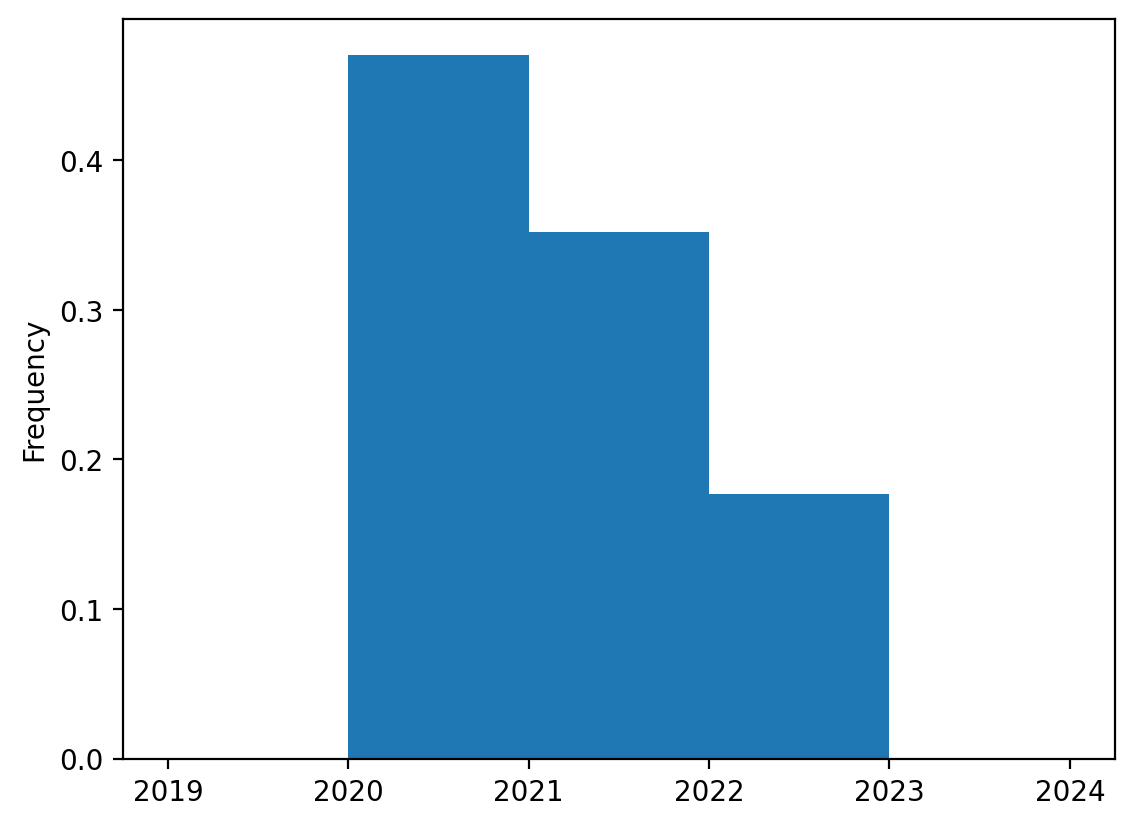

In [13]:
combined['disclosure_year'].plot(kind='hist', density=True, bins=range(2019,2025,1));

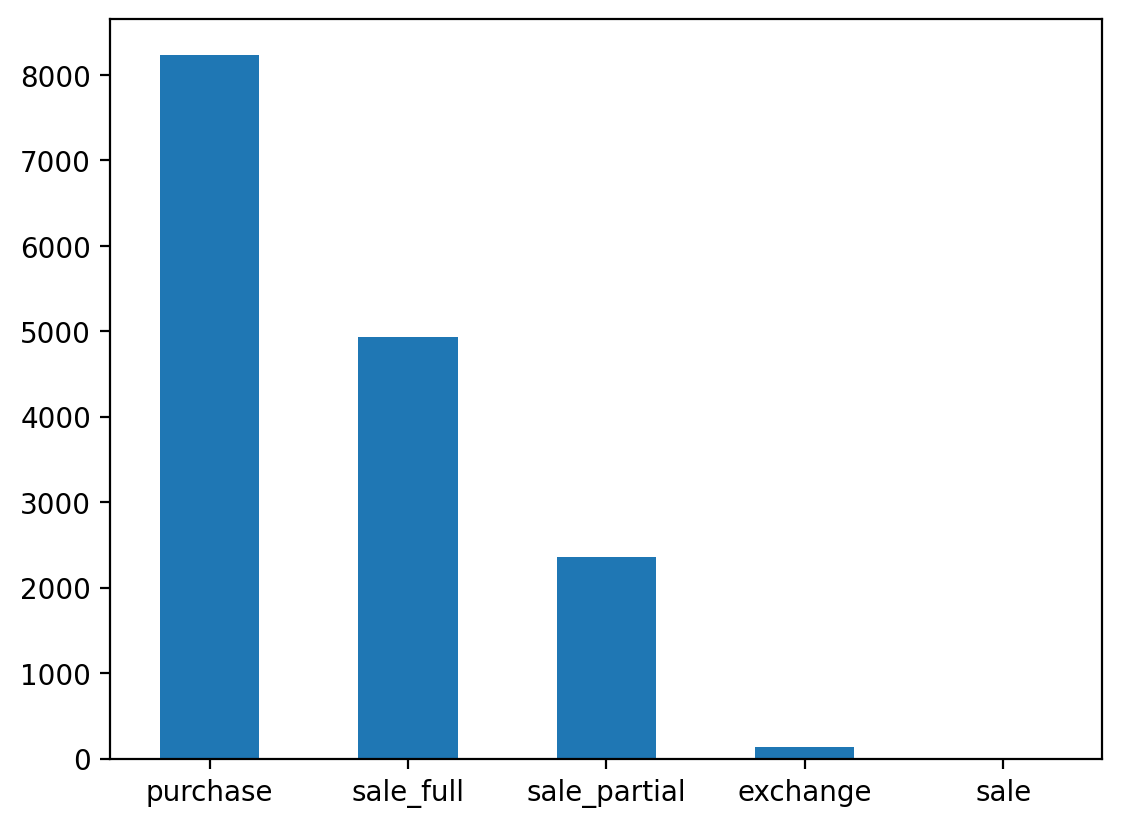

In [14]:
combined['type'].value_counts().plot(kind='bar')
plt.xticks(rotation=0);

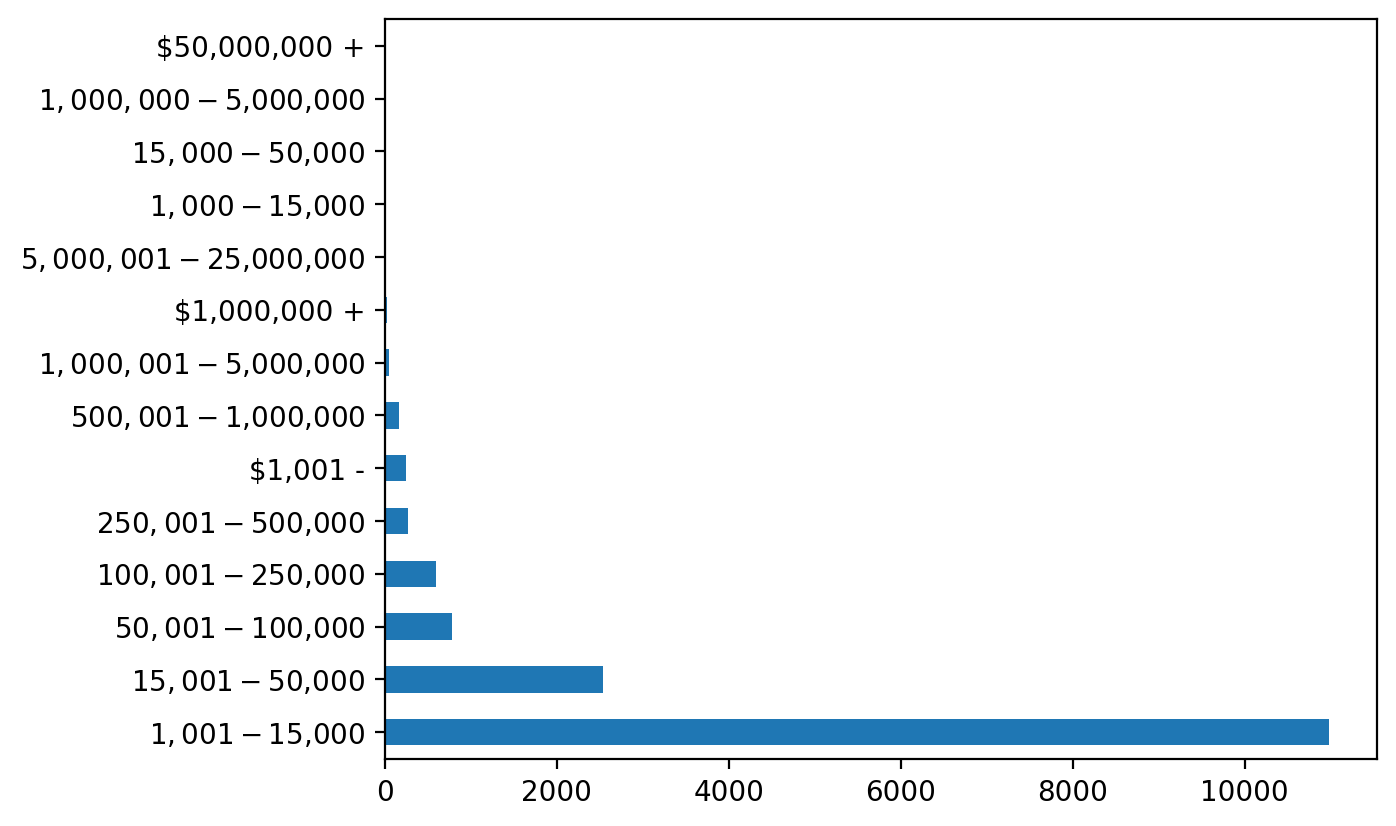

In [15]:
combined['amount'].value_counts().plot(kind='barh');

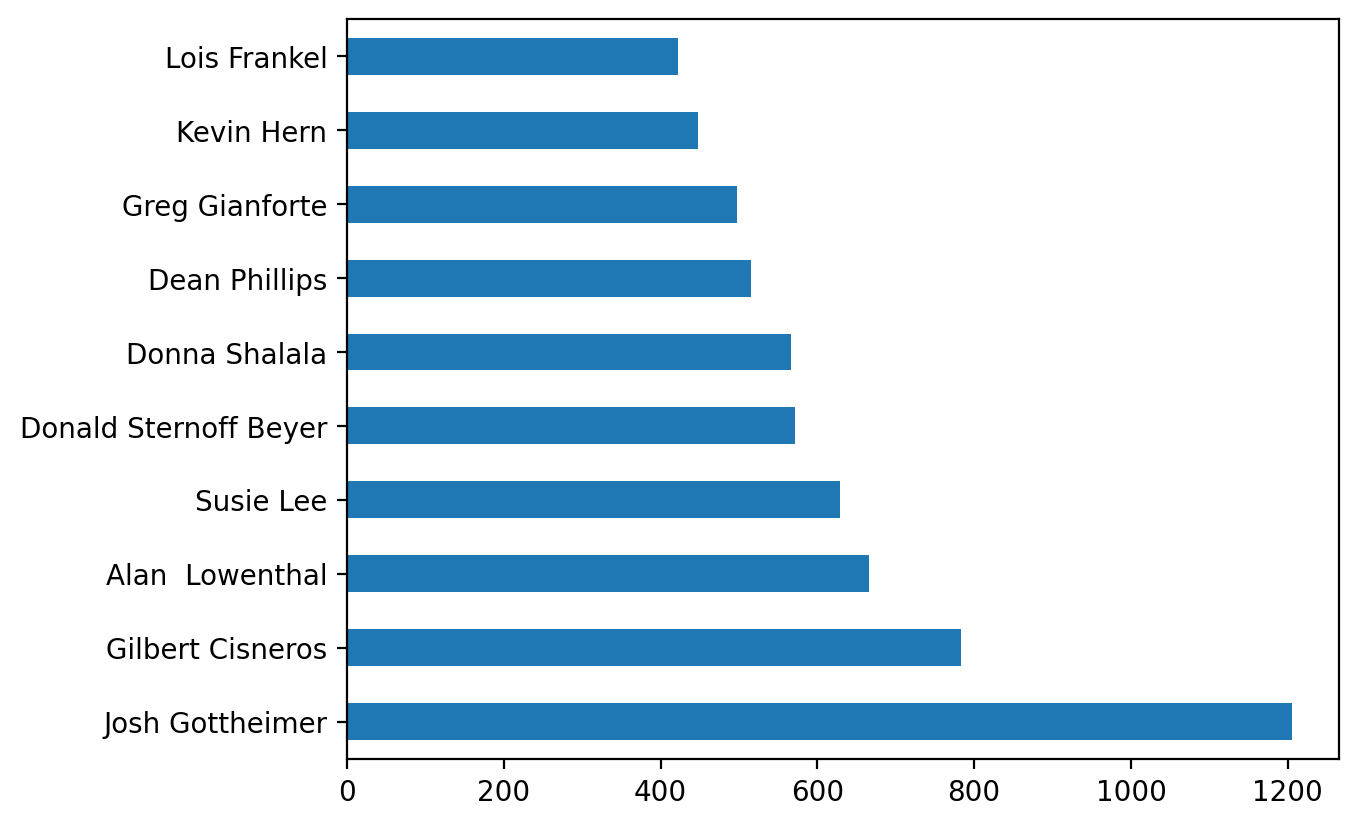

In [16]:
combined['representative'].value_counts().head(10).plot(kind='barh');

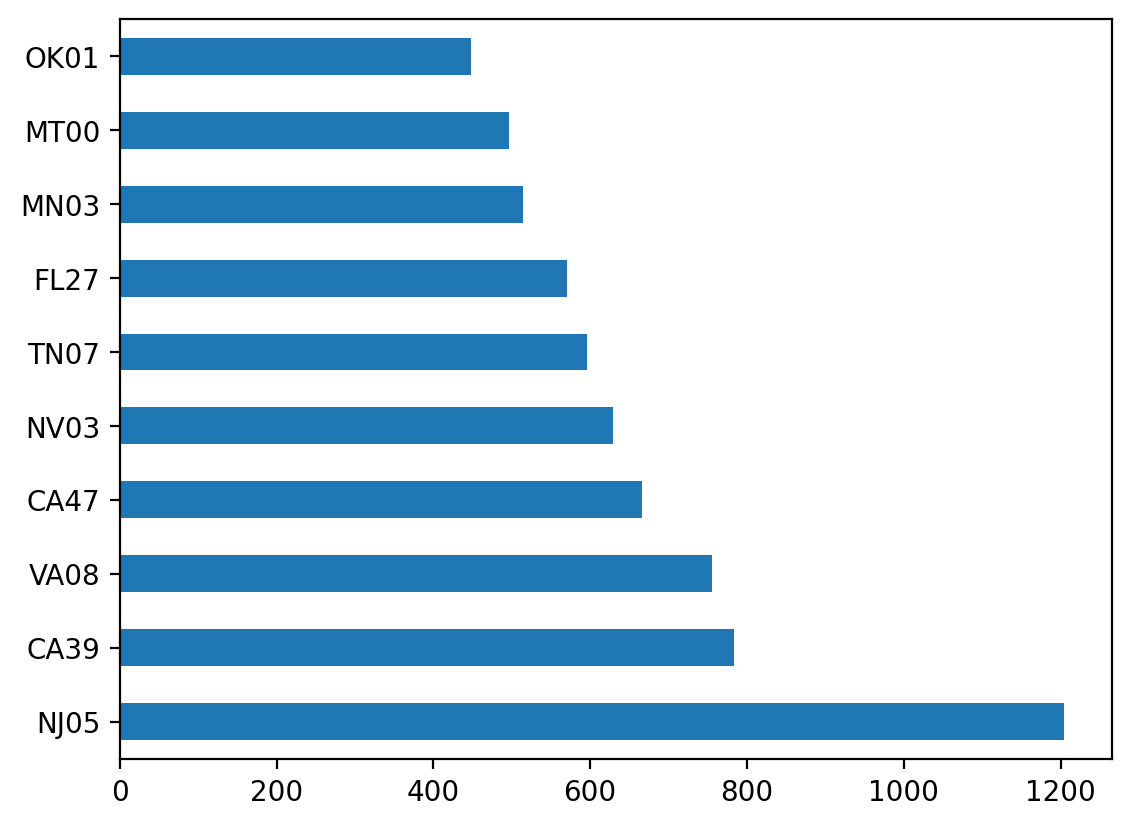

In [17]:
combined['district'].value_counts().head(10).plot(kind='barh');

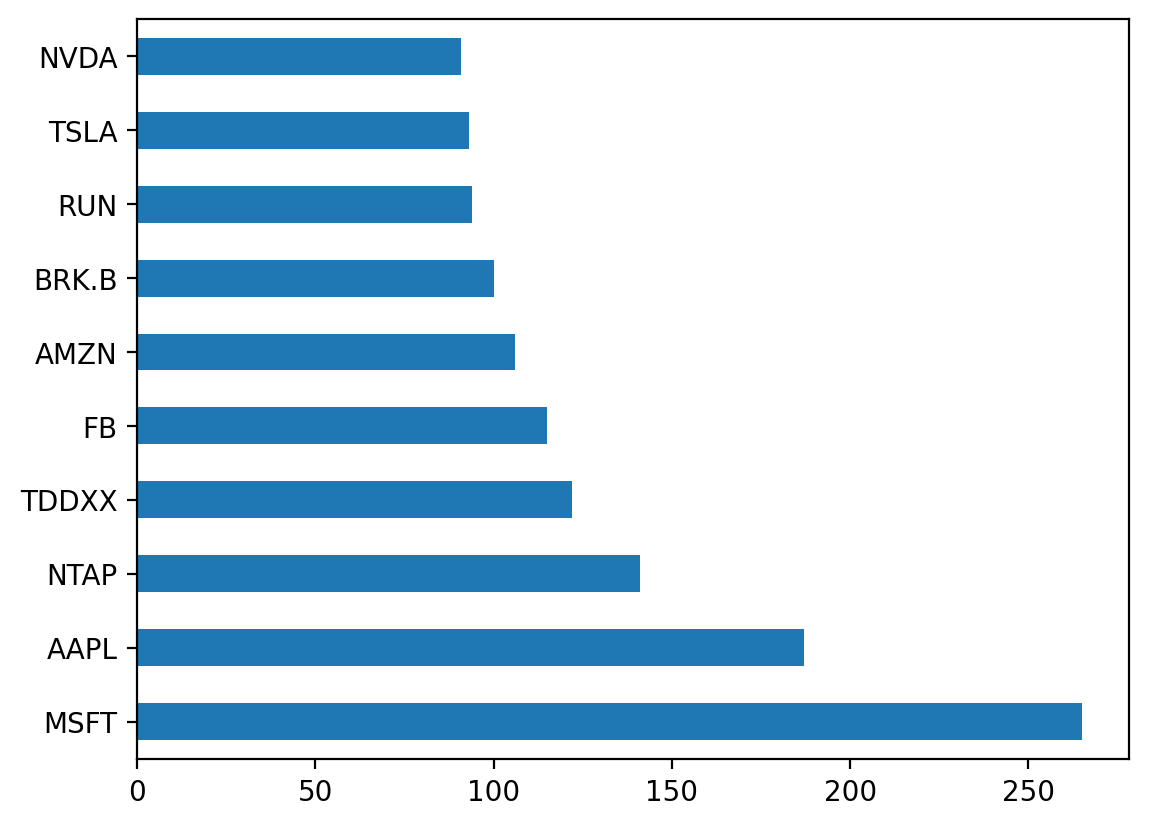

In [18]:
combined['ticker'].value_counts().head(10).plot(kind='barh');

### Assessment of Missingness

In [19]:
# find columns having missing datas
combined.isna().sum()

disclosure_year              0
disclosure_date              0
transaction_date             7
owner                     6013
ticker                    1296
asset_description            4
type                         0
amount                       0
representative               0
district                     0
ptr_link                     0
cap_gains_over_200_usd       0
first_name                   0
last_name                    0
party                        0
dtype: int64

In [20]:
combined['owner'] = combined['owner'].replace('--', np.NaN)

- two columns we have to take closer look is owner and ticker in which having the most missingness
    - assess whether owner is MAR or MCAR
    - assess whether ticker is MAR or MCAR

In [21]:
def calc_tvd(df, missing_col, col):
    dist = (
        df
        .assign(**{f'{missing_col}_null': df[missing_col].isna()})
        .pivot_table(index=col, columns=f'{missing_col}_null', aggfunc='size', fill_value=0)
    )
    dist = dist / dist.sum()
    return dist.diff(axis=1).iloc[:, -1].abs().sum() / 2


def missingness_perm_test(df, missing_col, col):
    shuffled = df.copy()
    shuffled[f'{missing_col}_null'] = shuffled[missing_col].isna()
    
    obs_tvd = calc_tvd(df, missing_col, col)

    n_repetitions = 1000
    tvds = []
    for _ in range(n_repetitions):

        # Shuffling genders and assigning back to the DataFrame
        shuffled[col] = np.random.permutation(shuffled[col])

        # Computing and storing TVD
        tvd = calc_tvd(shuffled, missing_col, col)
        tvds.append(tvd)

    tvds = np.array(tvds)
    pval = np.mean(tvds >= obs_tvd)
    
    # Draw the p-value graph
    pd.Series(tvds).plot(kind='hist', density=True, ec='w', bins=10, title=f'p-value: {pval}', label='Simulated TVDs')
    plt.axvline(x=obs_tvd, color='red', linewidth=4, label='Observed TVD')
    plt.legend()
    plt.show()
    
    return pval

determine the relationship of owner missingness with col [type, amount, representative]

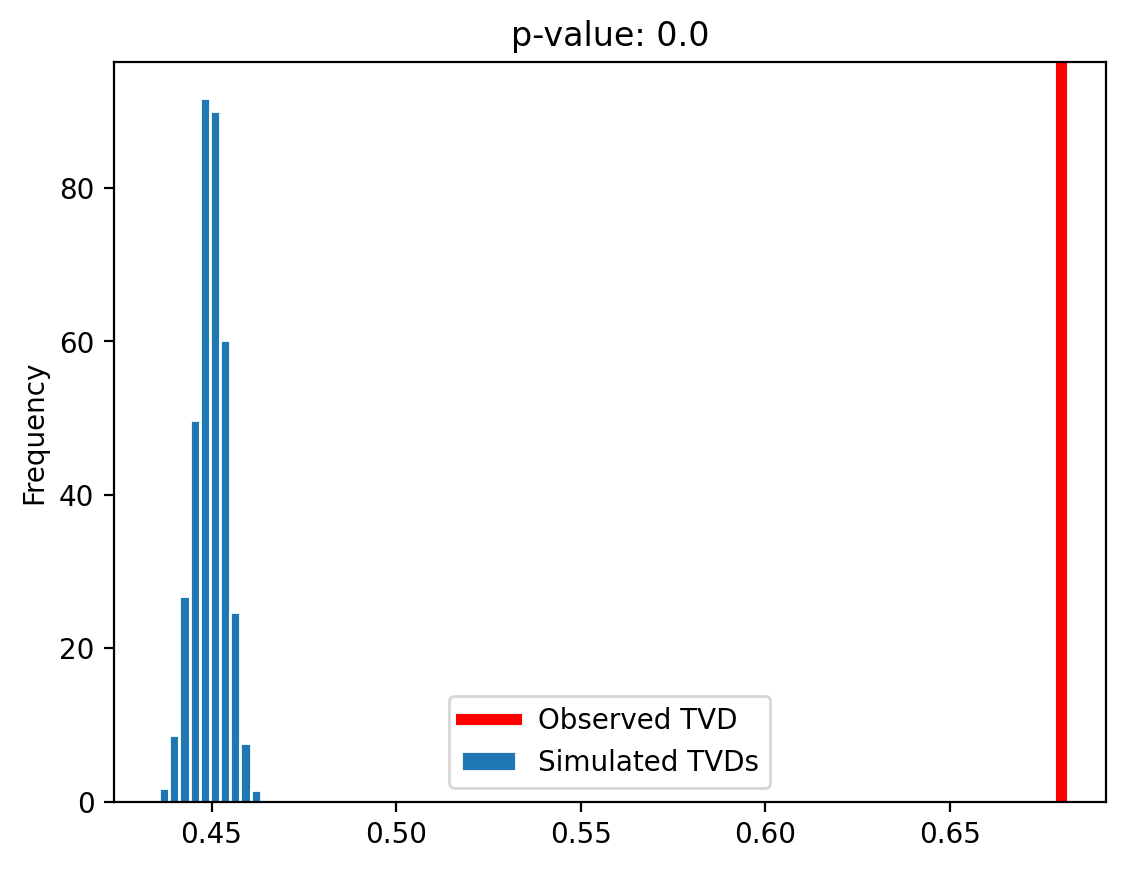

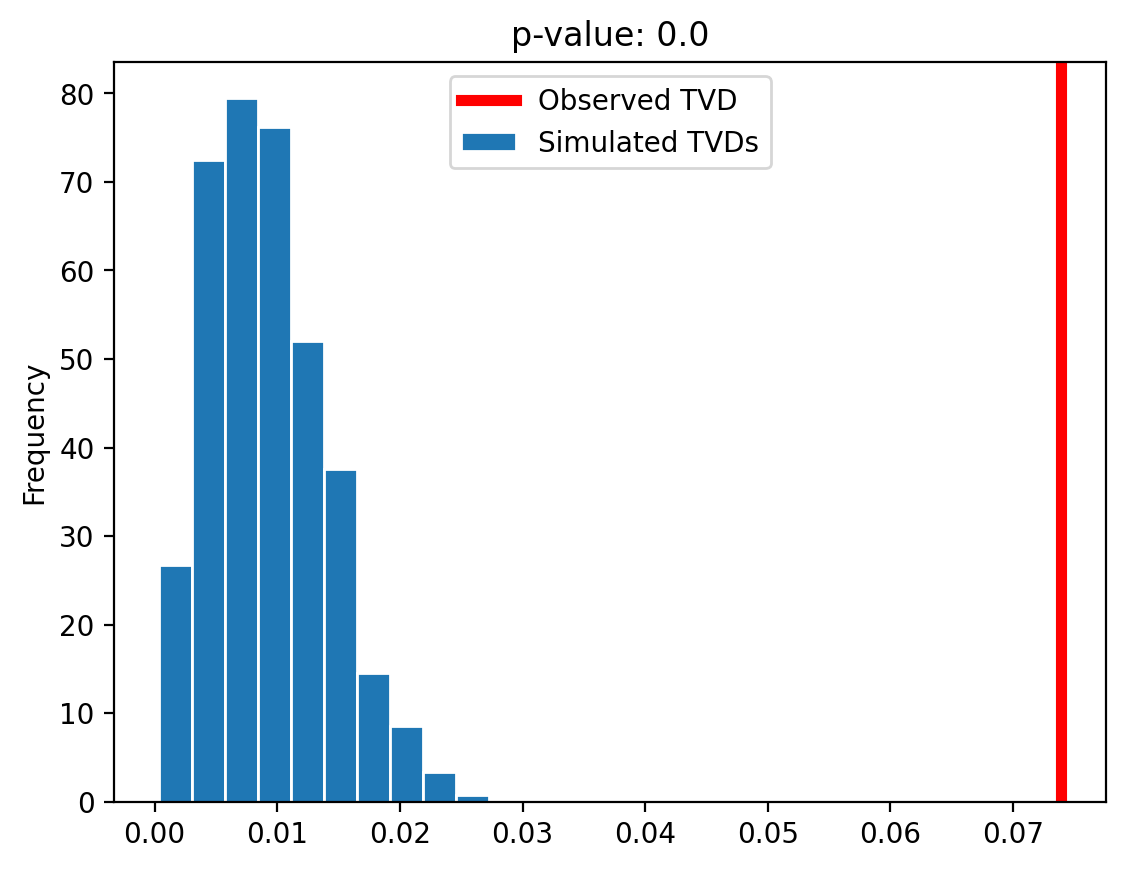

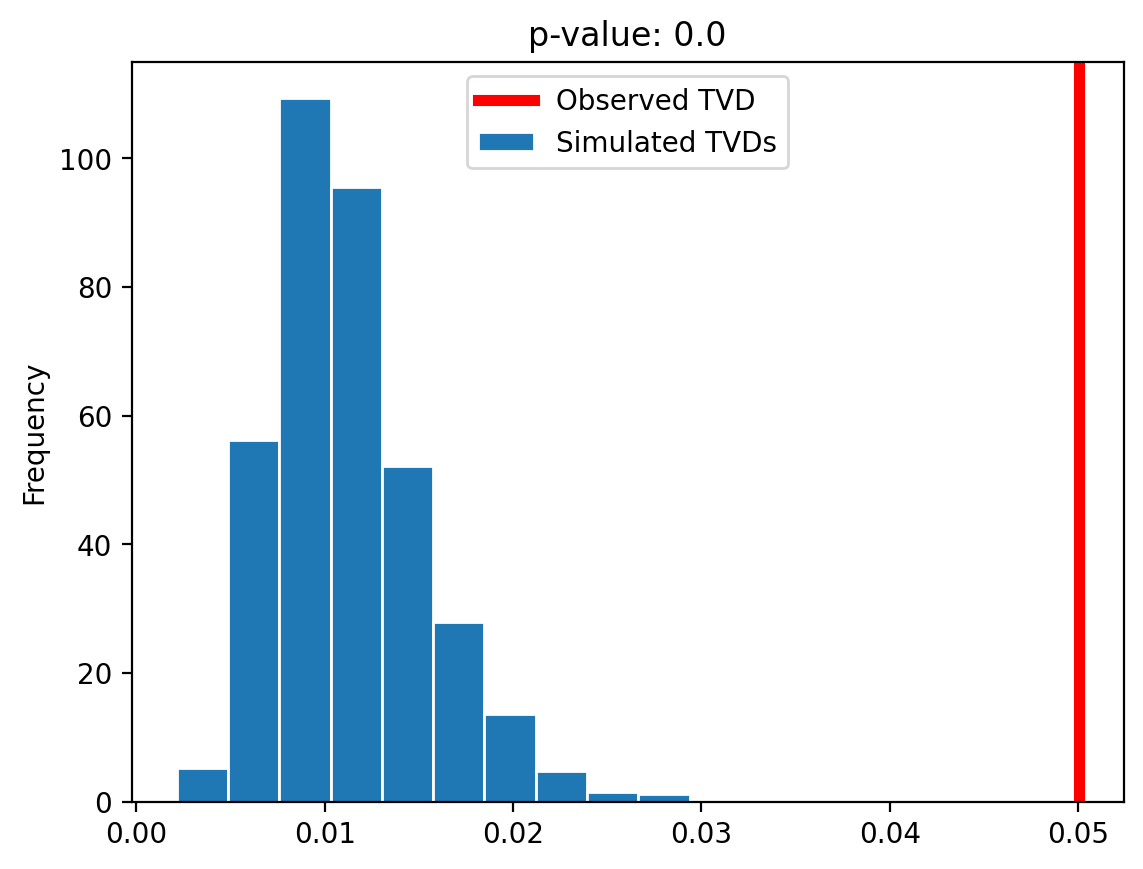

[0.0, 0.0, 0.0]

In [22]:
p_val = []
for col in combined.columns[5:8]:
    p_val.append(missingness_perm_test(combined, 'owner', col))
p_val
# we determined the missing values in owner are MAR

determine the relationship of ticker missingness with col [type, amount, representative]

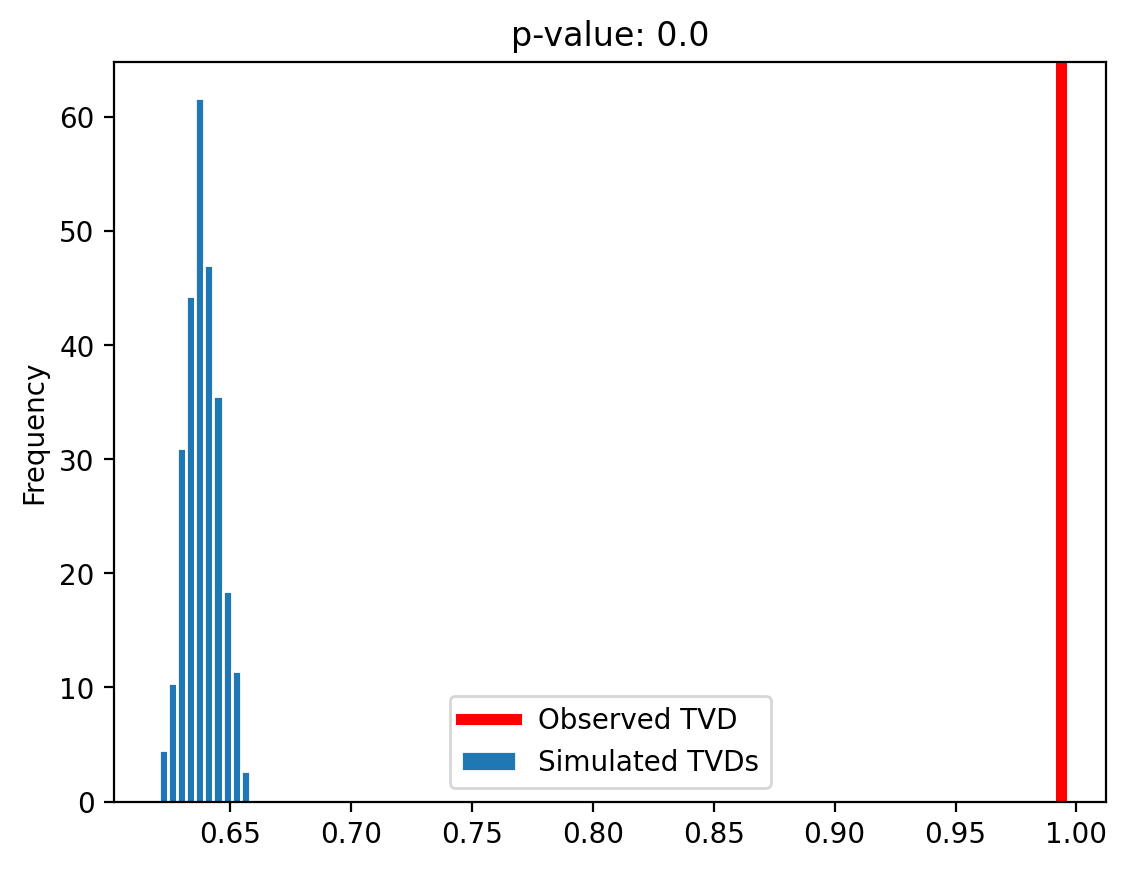

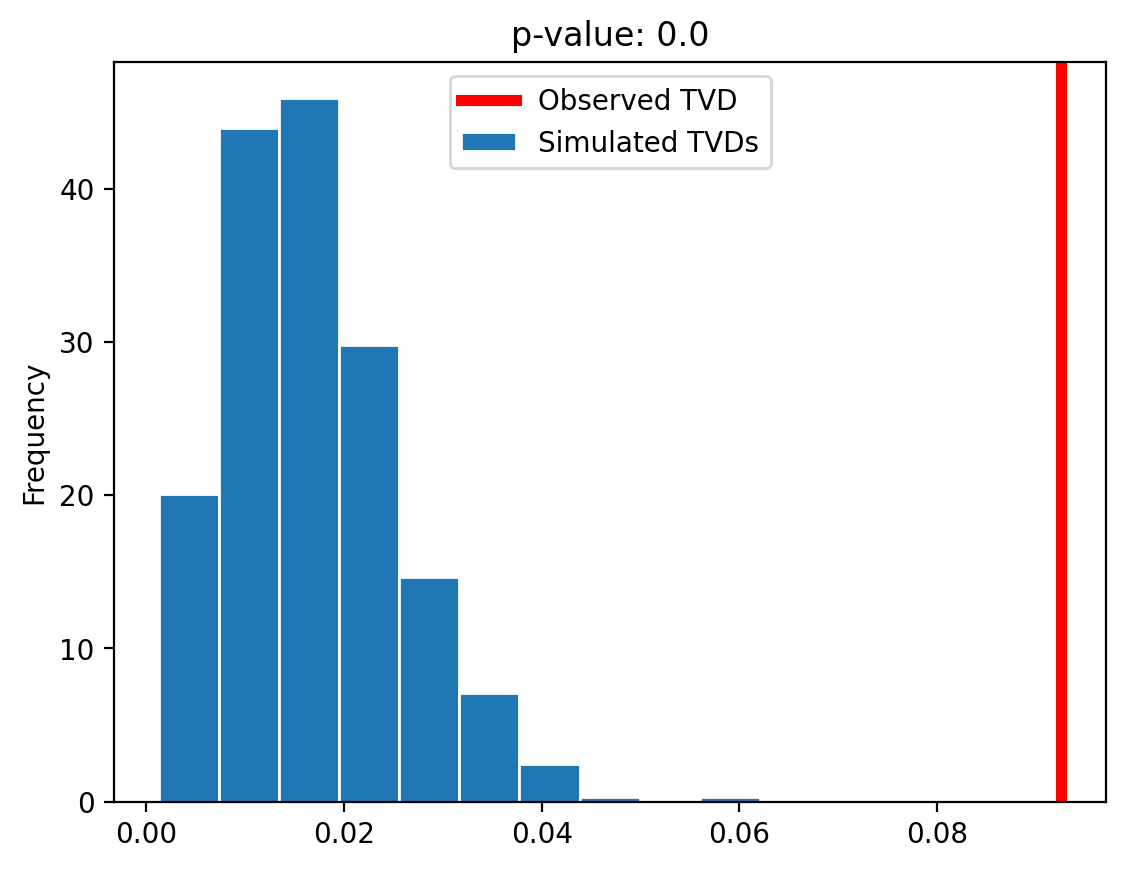

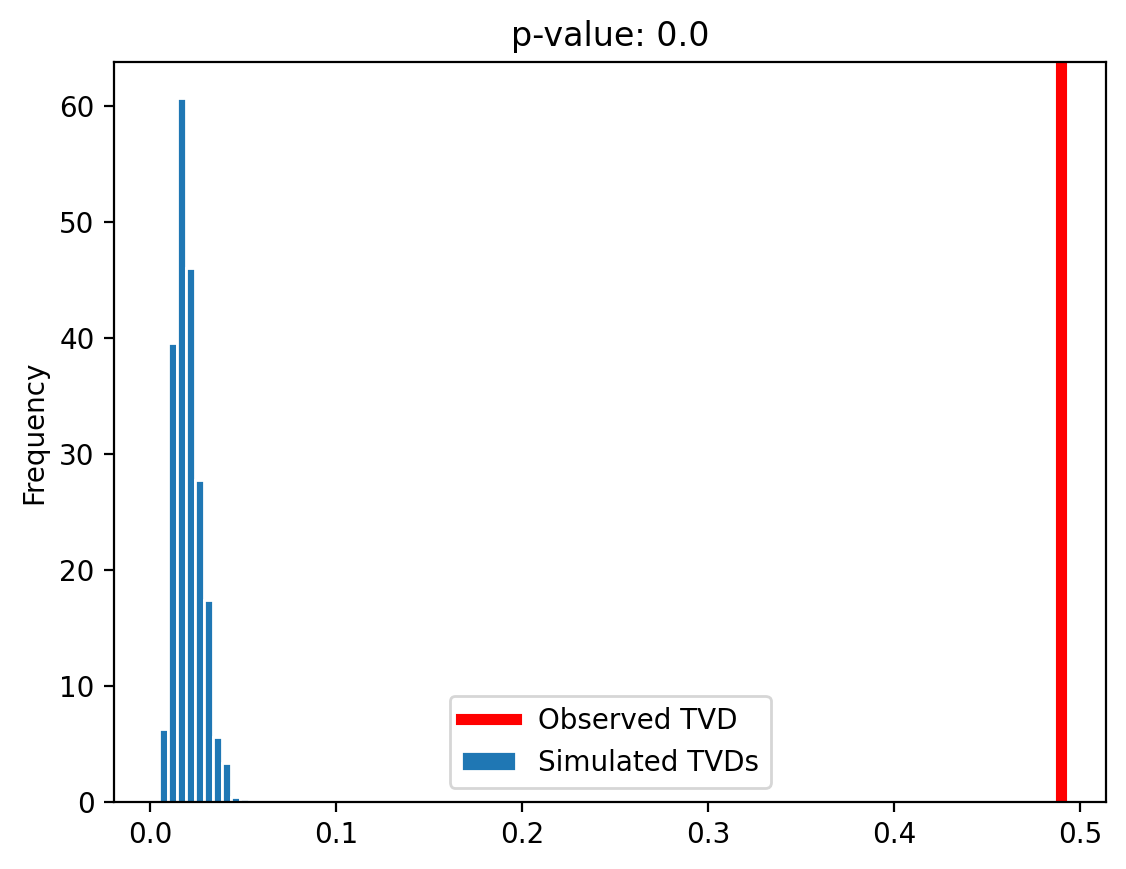

[0.0, 0.0, 0.0]

In [23]:
p_vals = []
for col in combined.columns[5:8]:
    p_vals.append(missingness_perm_test(combined, 'ticker', col))
p_vals
# we determined the missing values in ticker are MAR

So we conclude that the missingness of `owner` is __MAR__, and it's dependent on `type` column the most. 

### Hypothesis Test / Permutation Test


#### Which party trade more often?

* **Null hypothesis**: the distribution of trading frequency among congresspeople from different party is the same. The difference between the two observed sample is due to chance.

* **Alternative hypothesis**: the distribution of trading frequency among congresspeople from different party are different.

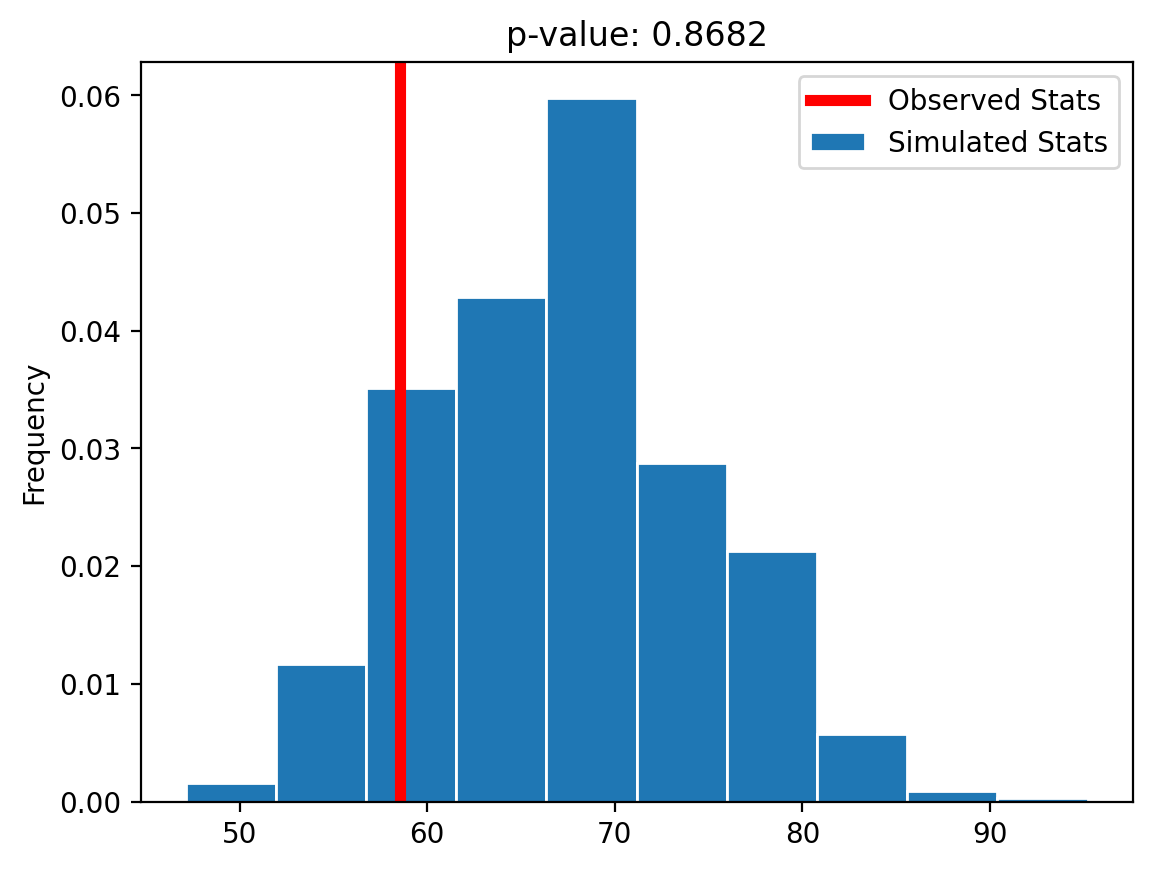

In [24]:
df = combined.assign(transaction_year=combined['transaction_date'].dt.year,
                     transaction_month=combined['transaction_date'].dt.month)
df = (
    df
    .groupby(['transaction_year', 'transaction_month', 'party'])[['representative']]
    .count()
    .reset_index()
)
democrat_stats = df.loc[df['party'] == 'Democrat', 'representative'].sum() / (df['party'] == 'Democrat').sum()
republican_stats =  df.loc[df['party'] == 'Republican', 'representative'].sum() / (df['party'] == 'Republican').sum()

obs_stats = abs(democrat_stats - republican_stats)

shuffled = combined.assign(transaction_year=combined['transaction_date'].dt.year,
                           transaction_month=combined['transaction_date'].dt.month)

n_repetitions = 5000
stats = []
for _ in range(n_repetitions):
    
    # Shuffling genders and assigning back to the DataFrame
    shuffled['party'] = np.random.permutation(shuffled['party'])
    
    # Computing and storing TVD
    pivoted = (
        shuffled
        .groupby(['transaction_year', 'transaction_month', 'party'])[['representative']]
        .count()
        .reset_index()
    )
    
    democrat_stats = pivoted.loc[pivoted['party'] == 'Democrat', 'representative'].sum() / (pivoted['party'] == 'Democrat').sum()
    republican_stats =  pivoted.loc[pivoted['party'] == 'Republican', 'representative'].sum() / (pivoted['party'] == 'Republican').sum()
    stats.append(abs(democrat_stats - republican_stats))
    
stats = np.array(stats)
pval = np.mean(stats >= obs_stats)

pd.Series(stats).plot(kind='hist', density=True, ec='w', bins=10, title=f'p-value: {pval}', label='Simulated Stats')
plt.axvline(x=obs_stats, color='red', linewidth=4, label='Observed Stats')
plt.legend();

#### Conclusion

The p-value of the permutation test is `0.8722`, which is way larger the the `0.05`. Thus, we __fail to reject__ the null hypothesis, which means that distribution of trading frequency among congresspeople from different party may be the same.

#### Which party make larger trades?

* **Null hypothesis**: the distribution of trading amount among congresspeople from different party is the same. The difference between the two observed samples is due to chance.

* **Alternative hypothesis**: In the US, the distributions of trading amount of the two groups are different.

In [14]:
cb_copy = combined.copy()
cb_copy['amount'] = cb_copy['amount'].str.split(' - ')




def transform(df):
    return int(df['amount'][0].strip('$').replace(',','').replace(' -','').replace(' +',''))

cb_copy['amount'] = cb_copy.apply(transform, axis = 1)

In [18]:
cb_copy = cb_copy.assign(transaction_year=combined['transaction_date'].dt.year,
                     transaction_month=combined['transaction_date'].dt.month)
cb_copy

cb_copy.to_csv("data/Congress_Trading_Behavior.csv")

<AxesSubplot:ylabel='transaction_month'>

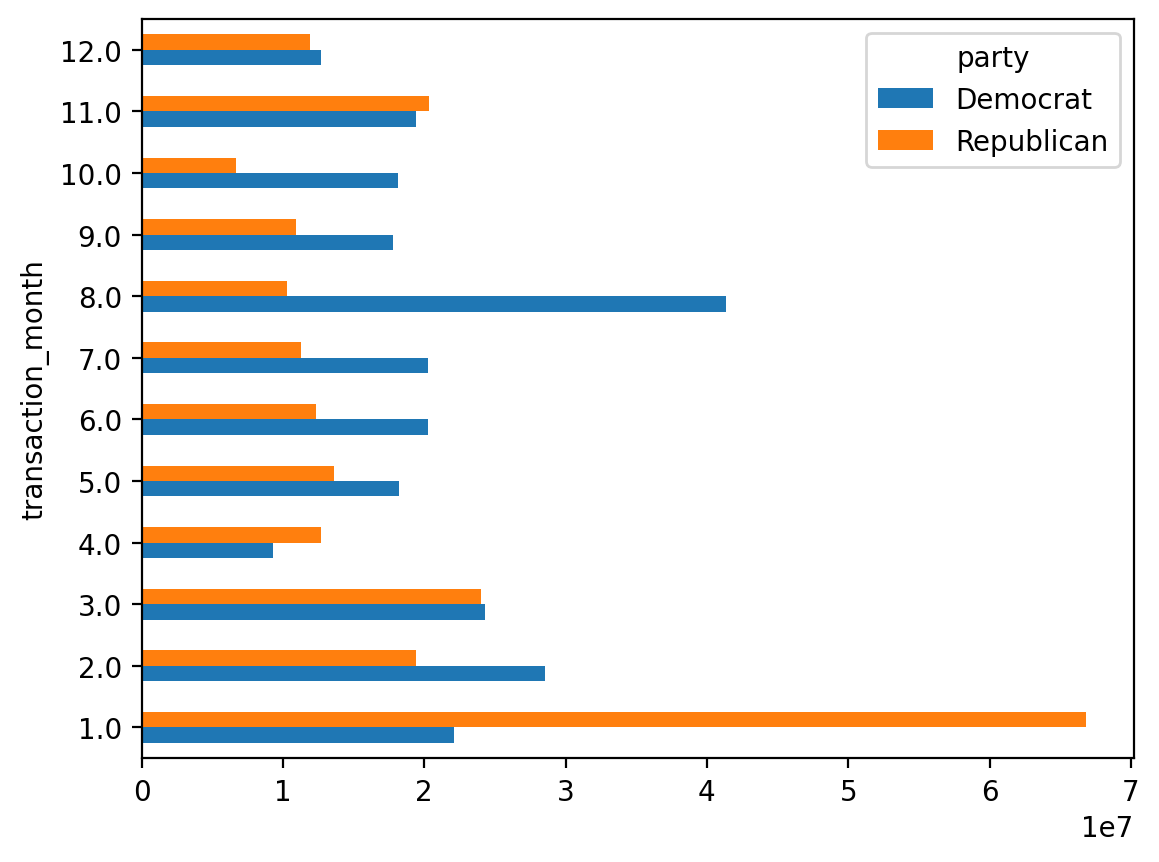

In [27]:
total_trade = pd.pivot_table(cb_copy, values='amount', index='transaction_month', columns='party',aggfunc='sum').drop(columns='Independent')
total_trade.plot(kind='barh')

obs 11862.298356514457 pval 0.0318


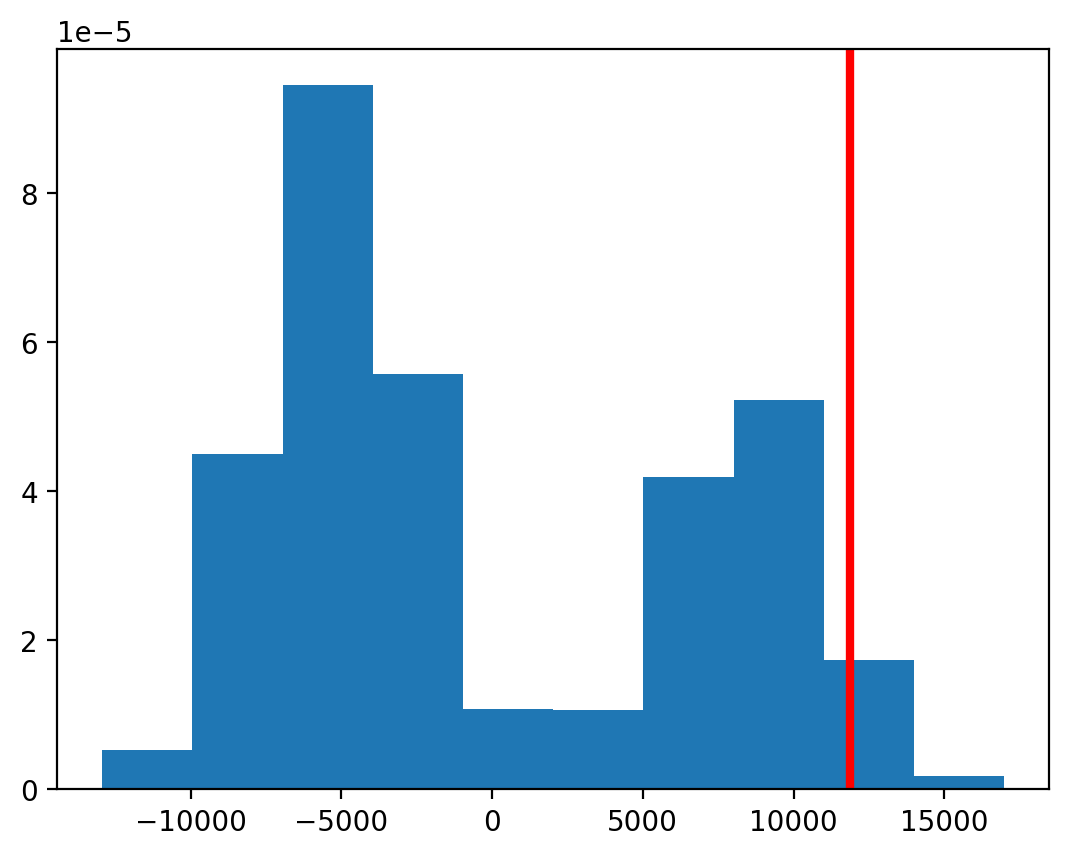

In [28]:
distr = cb_copy[['party','amount']]
distr = distr[distr['party'] != 'Independent']

obs_diff = distr.groupby('party').mean().diff().iloc[-1][0]

n_repetitions = 5000

differences = []
for _ in range(n_repetitions):
    
    shuffled_party= (
        distr['party']
        .sample(frac=1)
        .reset_index(drop=True) 
    )
    
    shuffled = (
        distr
        .assign(**{'shuffled_party': shuffled_party})
    )
    
    # Step 3: Compute the test statistic
    group_means = (
        shuffled
        .groupby('shuffled_party')
        .mean()
        .loc[:, 'amount']
    )
    difference = group_means.diff().iloc[-1]
    
    # Step 4: Store the result
    differences.append(difference)
    
pval = (np.array(differences) >= obs_diff).mean()
print('obs', obs_diff,'pval', pval)
plt.hist(differences, density=True)
plt.axvline(x=obs_diff, color='red', linewidth=3, label='P-value')


**Null hypothesis** we reject the null and conclude there might be chance of two group having difference trading amount

#### What congresspeople have made the most trades (amount)? 
- Kevin Hern with trade amount of  $ 68733447 in total

In [29]:
cb_copy.groupby('representative')['amount'].sum().idxmax()

'Kevin Hern'

#### What companies are most traded by congresspeople?

- Microsoft (MSFT)

In [30]:
cb_copy.groupby('ticker')['representative'].count().idxmax()

'MSFT'

#### When are stocks bought and sold? Is there a day of the week that is most common? Or a month of the year?

Thursday, Feburary

In [31]:
def to_weekday(x):
    day = x.weekday()
    if day == 0:
        return 'Monday'
    elif day == 1:
        return 'Tuesday'
    elif day == 2:
        return 'Wednesday'
    elif day == 3:
        return 'Thursday'
    elif day == 4:
        return 'Friday'
    elif day == 5:
        return 'Saturday'
    else:
        return 'Sunday'

df = combined.assign(weekday=combined['transaction_date'].apply(to_weekday))
df.groupby('weekday').count().rename(columns={'transaction_date': 'count'})['count'].idxmax()

'Thursday'

In [32]:
df = combined.assign(month=combined['transaction_date'].dt.month)
df.groupby('month').count().rename(columns={'transaction_date': 'count'})['count'].idxmax()

2.0